In [113]:
#导入基本的库和文件
import sys
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

data = pd.read_csv('./train.csv', encoding = 'big5')

In [114]:
# 数据基本处理
data = data.iloc[:,3:]  #去除掉表的前3列
data[data == 'NR'] = 0
raw_data = data.to_numpy()

In [115]:
#将数据分成18x480的矩阵，表示一个月20天的数据
month_data = {}
month = 0
x = 0
day = 0
while month < 12:
    temp = np.empty([18,480]) #这个矩阵不为空,只是随机生成个XxY的矩阵罢了
    y = 0
    day = 0
    while  day < 20:
        temp[:,y : (y+24)] = raw_data[x : (x+18),:]
        x+=18
        y+=24
        day+=1
    month_data[month] = temp
    month +=1



In [116]:
x = np.empty([12 * 471, 18*9], dtype= float)  #x表示前9小时的数据，y表示导出的第10小时第数据
y = np.empty([12*471, 1], dtype= float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour >14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
#print(x)
#print(y)

In [117]:
#normalize
mean_x = np.mean(x, axis = 0)
std_x = np.std(x, axis = 0)
for i in range(len(x)):
    for j in range(len(x[0])):
        if std_x[j] !=0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]



0:27.071214829194115
100:10.410459563902037
200:7.606850325936955
300:6.611978493495403
400:6.237278506123302
500:6.074245782654158
600:5.987083414549819
700:5.931056913094358
800:5.890465193375367
900:5.859030419626609


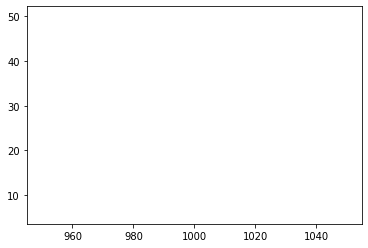

In [118]:
#train
dim = 18 * 9 + 1
w = np.zeros([dim, 1]) #全0矩阵
x = np.concatenate((np.ones([12 * 471, 1]), x), axis= 1).astype(float)
learning_rate = 0.895
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
iter_time = 1000
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x,w) - y, 2 ))/471/12) #rmse
    if t%100==0:
        print(str(t)+":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y)
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
    plt.plot(iter_time, loss)
np.save('weight.npy', w)
plt.show()

In [119]:
# testing
test_data = pd.read_csv('./test.csv', header= None, encoding= 'Big5')
test_data = test_data.iloc[:,2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype= float)
for i in range (240):
    test_x[i,:] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)  #数组拼接

In [120]:
#outport
w = np.load('weight.npy')
ans_y = np.dot(test_x, w) #矩阵乘法

with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        #print(row)